# Figure 1 from Sex-biased gene expression and alternative splicing. 

This notebook demonstrates how the results presented in Figure 1 of the manuscript were generated. Two of the five panels of Figure 1 are
generated by this script, panels (c) and (e).

## **Running this notebook**:

A few steps are needed before you can run this document on your own. The GitHub repository (https://github.com/TheJacksonLaboratory/sbas) of the project contains detailed instructions for setting up the environment in the **`dependencies/README.md`** document. Before starting with the analysis, make sure you have first completed the dependencies set up by following the instructions described there. If you have not done this already, you will need to close and restart this notebook before running it.

All paths defined in this Notebook are relative to the parent directory (repository). 

# 1. Setup
## 1.1 Loading dependencies

In [1]:
library(downloader)
library(readr)
library(edgeR)
library(biomaRt)
library(DBI) # v >= 1.1.0 required for biomaRt
library(devtools)
library(yarn)
library(statmod)
library(piggyback)
library(snakecase)
library(stringr)
library(pheatmap)
library(magrittr)
library(dplyr)
library(ggplot2)
library(scales)
library(viridis)
library(scales)

Sys.setenv(TAR = "/bin/tar") # for gzfile

Warning message:
“package ‘downloader’ was built under R version 3.6.3”Warning message:
“package ‘readr’ was built under R version 3.6.3”Loading required package: limma
Warning message:
“package ‘DBI’ was built under R version 3.6.3”Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lappl

## Figure 1c  Heatplot representing similarity in the fold-changes between male and female samples
First, we will generate Figure 1c. The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

## 1.2 Retrieving the GTEx archive

We used the R package [yarn](https://bioconductor.org/packages/release/bioc/html/yarn.html) to retrieve the GTEx Biobank data. In order to download the latest GTEx version (8.0) for RNA-seq and genotype data (phs000424.v8.v2), released 2019-08-26, we created a fork of the package's GitHub repository and created a new version of the function **`yarn::downloadGTEx()`**, namely **`yarn::downloadGTExV8()`** to download this release. 

We used the function to perform quality control, gene filtering and normalization pre-processing on the GTEx RNA-seq data. This pipeline tested for sample sex-misidentification, merged related sub-tissues and performed tissue-aware normalization using the **`{yarn::qsmooth}`**  function ([Paulson et al, 2017](https://pubmed.ncbi.nlm.nih.gov/28974199/)).

We have archived the output of the **`yarn::downloadGTExV8()`** function, which is an `ExpressionSet` object in the repo `lifebitai/lifebitCloudOSDREgtex` for replicability and decreasing the runtime of this analysis. Below we retrieve this `gtex.rds` object from the GitHub releases using the **`{ropensci/piggyback}`** package, but we have also added the relevant command to retrieve the data from GTEx and generate the `ExpressionSet` object using  **`yarn::downloadGTExV8()`**. For the current analysis we are utilising a compute resource with 8 vCPUs and 60 GB of memory available.

In [2]:
# Download with yarn if you wish, this requires several minutes to complete
if (!("gtex.rds" %in% list.files("../data/"))) {
    message("Downloading GTEx v8 with 'yarn::downloadGTExV8()'")
    obj <- yarn::downloadGTExV8(type='genes',file='../data/gtex.rds')
    message("Done!")

} else {
# Load with readRDS() if gtex.rds available in data/
    message("Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..\n")   
    obj <- readRDS(file = "../data/gtex.rds")
    message("Done!\n")
    message("Generating sha256sum for gtex.rds ..\n")    
    message(system("sha256sum ../data/gtex.rds", intern = TRUE))
    message("Done!\n")
} 
# Confirm that it is an expression set.
# and check the dimensions of the objects, and the phenotype information of the objects
class(obj) 
dim(phenoData(obj))
dim(obj)

Loading GTEx v8 rds object with readRDS from ../data/gtex.rds ..

Done!

Generating sha256sum for gtex.rds ..

18e2c7a83c98dcf59ddab53e1281923979d49da6ea3acb68114c5a44057c57bc  ../data/gtex.rds
Done!



[1] "ExpressionSet"
attr(,"package")
[1] "Biobase"

rowNames columnNames 
      17384          67

Features  Samples 
   55878    17382

## 1.3 download the Annotation file saved from getting the GTEx Fastq's

This is the annotation file as organized by dbGaP, we use yarn as the annotations for sex have been noted to be incorrect.
This file and the object from yarn will be joined in this way the differences can be noted, and managed.

In [3]:
# If the SraRunTable from SRA's dbGaP not already in our directories, download with SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz 
# the annotations in this file have errors -- so for the samples we will use the yarn annotations
if (!("SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz" %in% list.files("../data/"))) {
    piggyback::pb_download(
        repo = "TheJacksonLaboratory/sbas", 
        file = "SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz",
        tag  = "GTExV8.v1.0", 
        dest = "../data/")
    metadata          <- data.table::fread("../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz")
} else {
    metadata          <- data.table::fread("../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt.gz")
    
}

## 1.4: Quality control, preprocessing of data 

We observed above that our phenotype data have 2 more observations than our expression data. Let's inspect what these samples are:

In [4]:
sample_names=as.vector(as.character(colnames(exprs(obj))))
length(sample_names)

pheno_sample_names=as.vector(as.character(rownames(pData(obj))))
length(pheno_sample_names)

if (length(pheno_sample_names) > length(sample_names)) {
    superset <- pheno_sample_names
    subset   <- sample_names    
} 

if (length(pheno_sample_names) < length(sample_names)) {
    superset <- sample_names
    subset   <- pheno_sample_names   
} 

non_overlaps <- setdiff( superset, subset)

message("The non-overlapping IDs between pheno and count data are:\n\n", 
        paste(non_overlaps, collapse = "\n") )


[1] 17382

[1] 17384

The non-overlapping IDs between pheno and count data are:

GTEX-YF7O-2326-101833-SM-5CVN9
GTEX-YEC3-1426-101806-SM-5PNXX


### 1.4.1 Let's keep only the overlapping IDs:

In [5]:
logical_match_names=superset %in% subset
length(logical_match_names)
table(logical_match_names)
pData(obj) <- (pData(obj)[logical_match_names==TRUE,])
dim(pData(obj))
dim(obj)

[1] 17384

logical_match_names
FALSE  TRUE 
    2 17382 

[1] 17382    67

Features  Samples 
   55878    17382

### 1.4.2   Replace all *dashes* with **dots "."**

In [6]:
pData(obj)$SAMPID[1]
pData(obj)$SAMPID <- gsub('-','\\.',pData(obj)$SAMPID)
pData(obj)$SAMPID[1]

GTEX-1117F-0226-SM-5GZZ7 
GTEX-1117F-0226-SM-5GZZ7 
22951 Levels: GTEX-1117F-0003-SM-58Q7G ... K-562-SM-E9EZZ

[1] "GTEX.1117F.0226.SM.5GZZ7"

### 1.4.3   Create a matching ID in the meta_data data structure and then join

The yarn variable for annotated sex is encoded in `SEX` and the metadata to-be-corrected sex annotation in meta_data  datastructure is `sex`

In [7]:
metadata$SAMPID  <- gsub('-','\\.',metadata$'Sample Name')
tail(metadata$SAMPID)
tail(pData(obj)$SAMPID)
metadata_pData <- dplyr::left_join(metadata, pData(obj), by = "SAMPID")
table(metadata_pData$sex)
table(metadata_pData$SEX)

[1] "GTEX.YB5K.2126.SM.4WWDJ"  "GTEX.12KS4.0826.SM.5BC5R"
[3] "GTEX.111VG.2326.SM.5N9BK" "GTEX.111VG.1926.SM.5GIDO"
[5] "GTEX.ZV7C.2026.SM.5NQ8F"  "GTEX.12ZZY.0426.SM.5LZW3"

[1] "GTEX.ZZPU.1826.SM.5E43L" "GTEX.ZZPU.2126.SM.5EGIU"
[3] "GTEX.ZZPU.2226.SM.5EGIV" "GTEX.ZZPU.2426.SM.5E44I"
[5] "GTEX.ZZPU.2626.SM.5E45Y" "GTEX.ZZPU.2726.SM.5NQ8O"


       female   male 
     6   3688   6090 


   1    2 
5579 3202 

### 1.4.4 now reduce the express object to the same size

In [8]:
sample_names=as.vector(as.character(colnames(exprs(obj))))
sample_names<- gsub('-','\\.',sample_names)
length(sample_names)

metadata_sample_names = as.vector(as.character(metadata_pData$SAMPID))
if (length(metadata_sample_names) > length(sample_names)) {
    superset <- metadata_sample_names
    subset   <- sample_names    
} 

if (length(metadata_sample_names) < length(sample_names)) {
    superset <- sample_names
    subset   <- metadata_sample_names   
} 

non_overlaps <- setdiff( superset, subset)

message("The number of non-overlapping IDs between pheno and count data are:\n\n", 
        paste(length(non_overlaps), collapse = "\n") )
logical_match_names=superset %in% subset
length(logical_match_names)
table(logical_match_names)

obj            <- obj           [                         ,logical_match_names==TRUE]
metadata_pData <- metadata_pData[logical_match_names==TRUE,                         ]

dim(pData(obj))
dim(obj)
dim(exprs(obj))
dim(metadata_pData)

[1] 17382

The number of non-overlapping IDs between pheno and count data are:

8729


[1] 17382

logical_match_names
FALSE  TRUE 
 8729  8653 

[1] 8653   67

Features  Samples 
   55878     8653

[1] 55878  8653

[1] 8653  146

# 2.  Differential Expression using `edgeR`

##  2.1  For each tissue, model gene expression by tissue

Differential Analysis (DE) was performed using voom (Law et.al., 2014) with gene expression counts with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma. 

Within each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression:


           y = B0 + B1 sex + epsilon (error)
           

where y is the gene expression to be modeled sex denotes the reported sex of the subject

###   2.1.1 remove all zero rows

In [48]:
y_rowsums <- rowSums(exprs(obj))
is_zero   <- y_rowsums == 0
table(is_zero)

reduced_obj  <- obj           [is_zero==FALSE,]

dim(pData(reduced_obj))
dim(reduced_obj)
dim(exprs(reduced_obj))
dim(metadata_pData)

is_zero
FALSE  TRUE 
55820    58 

[1] 8653   67

Features  Samples 
   55820     8653

[1] 55820  8653

[1] 8653  146

###   2.1.2 Limit to select tissues matching minimal sample criteria

At a minimum of 50 samples are required to ensure a respectable differential analysis -- assessing the distrubtion of sexes and avaiability of samples - a reduced list is obtained, and alternative naming structure - so that display names are more visible in all graphics.

In [59]:
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")

# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

# create a matching tissue name to go with the expressionSet phenotype object
pData(reduced_obj)$tissue <- factor(snakecase::to_snake_case(as.character(pData(reduced_obj)$SMTSD)))
tissue_names_keep <- pData(reduced_obj)$tissue %in% tissue_reduction$SMTSD
table(tissue_names_keep)

# reduced the expressionSet object to only those tissues we wish to keep
reduced_obj  <- reduced_obj [,tissue_names_keep==TRUE]
dim(reduced_obj)
dim(exprs(reduced_obj))
dim(pData(reduced_obj))
table(pData(reduced_obj)$tissue)


 0  1 
11 39 

tissue_names_keep
TRUE 
7740 

Features  Samples 
   55820     7740

[1] 55820  7740

[1] 7740   68


                 adipose_subcutaneous              adipose_visceral_omentum 
                                  327                                   226 
                        adrenal_gland                          artery_aorta 
                                  152                                   235 
                      artery_coronary                         artery_tibial 
                                  132                                   338 
          brain_caudate_basal_ganglia           brain_cerebellar_hemisphere 
                                  120                                   105 
                     brain_cerebellum                          brain_cortex 
                                  125                                   116 
            brain_frontal_cortex_ba_9                     brain_hippocampus 
                                  110                                    95 
                   brain_hypothalamus brain_nucleus_accumbens_basal_ganglia

# 3. Separate the data by male and by female

In [60]:
reduced_male   <- pData(reduced_obj)$SEX==1
reduced_female <- pData(reduced_obj)$SEX==2

In [61]:
reduced_obj_male   <- reduced_obj[,reduced_male==TRUE]
reduced_obj_female <- reduced_obj[,reduced_female==TRUE]

In [62]:
dim(reduced_obj_male)
dim(reduced_obj_female)

Features  Samples 
   55820     4989

Features  Samples 
   55820     2751

In [63]:
# changing from SMTS to SMTSD - more granularity -- but we could produce both figures
tissue_groups_male <- factor(pData(reduced_obj_male)$tissue)
tissue_groups_female <- factor(pData(reduced_obj_female)$tissue)

In [64]:
# good sanity check, the male set does not have the tissues vagina or uterus
table (tissue_groups_male)

tissue_groups_male
                 adipose_subcutaneous              adipose_visceral_omentum 
                                  212                                   147 
                        adrenal_gland                          artery_aorta 
                                   86                                   144 
                      artery_coronary                         artery_tibial 
                                   78                                   220 
          brain_caudate_basal_ganglia           brain_cerebellar_hemisphere 
                                   86                                    75 
                     brain_cerebellum                          brain_cortex 
                                   85                                    79 
            brain_frontal_cortex_ba_9                     brain_hippocampus 
                                   78                                    66 
                   brain_hypothalamus brain_nucleus_accum

In [65]:
# and the females do not have the tissues prostate or testis
table(tissue_groups_female)

tissue_groups_female
                 adipose_subcutaneous              adipose_visceral_omentum 
                                  115                                    79 
                        adrenal_gland                          artery_aorta 
                                   66                                    91 
                      artery_coronary                         artery_tibial 
                                   54                                   118 
          brain_caudate_basal_ganglia           brain_cerebellar_hemisphere 
                                   34                                    30 
                     brain_cerebellum                          brain_cortex 
                                   40                                    37 
            brain_frontal_cortex_ba_9                     brain_hippocampus 
                                   32                                    29 
                   brain_hypothalamus brain_nucleus_acc

# 4. Differential gene analysis on a per tissue basis.
Loop through the tissues and for those tissues that are shared between the two sexes perform the analysis

In [66]:
tissue_groups <- factor(pData(reduced_obj)$tissue)
tissue_male_female <- tissue_groups_male %in% tissue_groups_female
table(tissue_male_female)
tissue_shared_male_female <- factor(tissue_groups_male[tissue_male_female])
table(tissue_shared_male_female)
# SEX is coded 1 == Male
#              2 == Female
sex = factor(pData(reduced_obj)$SEX)

tissue_male_female
TRUE 
4989 

tissue_shared_male_female
                 adipose_subcutaneous              adipose_visceral_omentum 
                                  212                                   147 
                        adrenal_gland                          artery_aorta 
                                   86                                   144 
                      artery_coronary                         artery_tibial 
                                   78                                   220 
          brain_caudate_basal_ganglia           brain_cerebellar_hemisphere 
                                   86                                    75 
                     brain_cerebellum                          brain_cortex 
                                   85                                    79 
            brain_frontal_cortex_ba_9                     brain_hippocampus 
                                   78                                    66 
                   brain_hypothalamus brain_nucleu

Let's now define a function named `fit_tissue()`that accepts two arguments, the `tissue` and an `object` and create the **model matrix** based  that tissue's sex. We will perform a linear fit after calculating normal factors (based on the library size) and calculate the dispersion using `voom` (mean variance model of dispersion). We are saving the resulting matrixes as files.


In [71]:
fit_tissue <- function (tissue, obj) {
    tissue_true             <- pData(obj)$tissue == tissue
    tissue_obj              <- obj[,tissue_true ==TRUE]
    tissue_sex              <- factor(pData(tissue_obj)$SEX)
    tissue_design           <- model.matrix(~tissue_sex)
    colnames(tissue_design) <- c("intercept","sex")
    
    y_tissue       <- DGEList(counts=exprs(tissue_obj), group=tissue_sex)
    y_tissue       <- calcNormFactors(y_tissue, method = "RLE")
    y_tissue_voom  <- voom(y_tissue, tissue_design)
    
    sex            <- ifelse(pData(tissue_obj)$SEX==1,'male','female')
    Gender         <- substring(sex,1,1)
    filename       <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue)),"-gene-y-MDSplot-100.pdf")
    pdf (filename)
        plotMDS(y_tissue, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()
    filename       <- paste0(paste0("../pdf/", snakecase::to_snake_case(tissue)),"-gene-y-voom-MDSplot-100.pdf")
    pdf (filename)    
        plotMDS(y_tissue_voom, labels=Gender, top=100, col=ifelse(Gender=="m","blue","red"), 
                gene.selection="common")
    dev.off()

    fit_tissue      <- lmFit(y_tissue_voom, tissue_design)
    fit_tissue      <- eBayes(fit_tissue, robust=TRUE)
    results_tissue  <- topTable (fit_tissue, coef='sex', number=nrow(y_tissue))
    results_refined <- results_tissue$adj.P.Val <= 0.05 & abs(results_tissue$logFC) >= abs(log2(1.5))

    filename  = paste(paste("../data",gsub(" ","",tissue), sep="/"),"DGE.csv", sep="_")
    rfilename = paste(paste("../data",gsub(" ","",tissue), sep="/"),"DGE_refined.csv", sep="_")
    
    write.table(results_tissue, filename, sep=',', quote=FALSE)
    write.table(results_tissue[results_refined,], rfilename, sep=',', quote=FALSE)
    return (results_tissue)
}

In [86]:
# debugging with using the 'Thyroid' tissue
#thyroid_logFC <- fit_tissue('Thyroid',reduced_obj)
#thyroid_logFC
# 
all_logFC <- lapply(X=levels(tissue_shared_male_female), FUN=fit_tissue, obj=reduced_obj)

In [87]:
dim(reduced_obj)[2]
length(levels(tissue_shared_male_female))

Samples 
   7740

[1] 39

In [88]:
filenames <- list.files("../data", pattern="*_DGE.csv", all.files=FALSE, full.names=TRUE)
length(filenames)
head(filenames)

[1] 39

[1] "../data/adipose_subcutaneous_DGE.csv"    
[2] "../data/adipose_visceral_omentum_DGE.csv"
[3] "../data/adrenal_gland_DGE.csv"           
[4] "../data/artery_aorta_DGE.csv"            
[5] "../data/artery_coronary_DGE.csv"         
[6] "../data/artery_tibial_DGE.csv"

In [89]:
# preserve the ordered rownames for later assignment to matrix
fullfilename <-filenames[1]
logFC_mat    <- read.csv(fullfilename)
logFC_mat    <- logFC_mat[order(rownames(logFC_mat)),]
logFC_mat_rownames <- as.character(rownames(logFC_mat)) 

In [90]:
# Make a matrix for each of the tissues
# from what files are saved
make_tissue_matrix_ready <- function (file) {
    filename        <- paste('../data',file,sep="/")
    logFC_mat       <- read.csv(filename)
    logFC_mat       <- logFC_mat[order(rownames(logFC_mat)),]
    logFC           <- as.matrix(as.numeric(logFC_mat$logFC),ncol=1)
    rownames(logFC) <- rownames(logFC_mat)
    return(logFC)
}

In [91]:
#matrix_list <- lapply(X=filenames, FUN=make_tissue_matrix_ready, obj=reduced_obj)
matrix_list <- lapply(X=filenames, FUN=make_tissue_matrix_ready)

In [92]:
length(matrix_list)
# rows are the number of samples, columns are the tissues
logFC_mat = as.matrix(lapply(X   = matrix_list, 
                             FUN = cbind),
                      nrow = dim(reduced_obj)[2], 
                      ncol = length(matrix_list))
length(logFC_mat)

[1] 39

[1] 39

In [93]:
tissue_list  <- levels(factor(pData(reduced_obj)$tissue))
length(tissue_list)

[1] 39

In [97]:
logFC_mat = as.matrix(as.numeric(unlist(matrix_list[1]),nrow=dim(reduced_obj)[2], ncol=1))

for (i in (2:length(matrix_list))) {
    n = as.matrix(as.numeric(unlist(matrix_list[i]),nrow=dim(reduced_obj)[2], ncol=1))
    logFC_mat = cbind(logFC_mat, n)
}

dim(logFC_mat)

display_name = ifelse(tissue_list == tissue_reduction$SMTSD, 
                                            tissue_reduction$display_name,
                                            logFC_mat_rownames)
head(display_name)
rownames(logFC_mat) = logFC_mat_rownames
colnames(logFC_mat) = display_name
head(logFC_mat)


[1] 55820    39

[1] "Adipose (sc)"    "Adipose (v)"     "Adrenal gland"   "Aorta"          
[5] "Coronary artery" "Tibial artery"

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
ENSG00000000003.14,0.175815967,-0.15592413,-0.03686557,0.011378129,0.107760332,0.055630679,0.04755382,0.40205639,0.14823066,0.261200922,⋯,0.07586806,0.094611476,-0.36264922,-0.03216503,0.06012754,0.08010895,0.04544853,7.824432e-02,-0.13018938,0.10850864
ENSG00000000005.5,0.396159591,-0.74216181,-0.59771305,0.396912635,0.313042869,0.155967608,-0.13024239,0.11325345,-0.35693538,0.138450827,⋯,-0.67092629,0.190250728,0.36748972,-0.32681845,0.28804554,0.61189542,0.45841936,2.305244e-01,0.05968081,-0.09442404
ENSG00000000419.12,0.004849441,0.01756121,0.08175986,-0.004386078,0.025101716,0.001570536,0.10457088,0.02991237,0.05922656,0.007754958,⋯,0.01462259,-0.053714045,-0.04130298,0.02911006,0.03310682,-0.05570492,0.01139893,-7.485000e-02,-0.04610996,0.14332182
ENSG00000000457.13,-0.020751206,0.01347088,-0.04928176,0.023127627,-0.007300490,0.070815345,0.07238892,0.04706482,0.03627217,0.025234442,⋯,0.02243884,-0.020189296,0.01230444,-0.05514675,-0.03424426,0.02176442,0.02401328,5.488274e-05,0.00107950,0.16368699
ENSG00000000460.16,-0.031968240,0.02430826,0.00636862,0.073736044,0.008484627,0.069424487,0.01960931,0.02530730,-0.06650336,0.066120037,⋯,0.01206103,-0.008332534,0.08259054,-0.01447248,-0.07663591,0.01483696,0.09545395,1.729335e-03,0.04035050,0.03524931
ENSG00000000938.12,0.283051221,0.17921035,-0.23699859,0.012362424,-0.032042455,0.018345301,0.15240596,0.32469934,0.40632521,0.441874192,⋯,0.12061208,-0.228166864,0.16338001,0.27922571,0.26039312,0.01840319,-0.19705786,-9.820948e-02,0.22385029,-0.01627731


In [137]:
#
#  remove the cells in the matrix that are <= abs(log2(1.5))
#   preserving only the values that are FC > 1.5
#
id <- which(rowSums(logFC_mat > abs(log2(1.5))) < 1)
logFC_gt_1.5 <- logFC_mat[id,]

dim(logFC_gt_1.5)


[1] 42189    39

In [142]:
logFC_mat_NQ <- normalizeQuantiles(logFC_gt_1.5)

In [143]:
head(logFC_mat_NQ)

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
ENSG00000000003.14,0.25689777,-0.16698537,0.02199142,0.03656667,0.143977041,0.10820022,0.09035362,0.26380935,0.12643045,0.13081502,⋯,-0.006004752,0.12207055,-0.28831259,0.00509609,0.07556498,0.099354685,0.068302398,0.10273549,-0.21628181,0.151393096
ENSG00000000419.12,0.06181409,0.03035204,0.14010461,0.01500290,0.036745776,0.02730617,0.15619241,0.01310349,0.05680378,-0.04848014,⋯,-0.048472507,-0.09191738,-0.06442667,0.06414350,0.03297348,0.000814937,0.038823125,-0.10124395,-0.11086051,0.192475736
ENSG00000000457.13,0.03812788,0.02557960,0.01307711,0.05333007,-0.022013150,0.13063691,0.11935954,0.02206956,0.03682465,-0.03909079,⋯,-0.041330397,-0.04722935,-0.02759834,-0.03365783,-0.06509028,0.055863404,0.049294708,0.01725871,-0.06270847,0.217145900
ENSG00000000460.16,0.02954549,0.03835831,0.05807523,0.12286852,-0.006992567,0.12870258,0.06258264,0.01070599,-0.07658201,-0.02288815,⋯,-0.050880634,-0.03097350,0.02822329,0.02247835,-0.11049672,0.050691283,0.114493660,0.01920353,-0.03622285,0.070473018
ENSG00000000938.12,0.36356437,0.19973247,-0.21068464,0.03780608,-0.043953623,0.05217954,0.20329392,0.19985575,0.34813184,0.32893787,⋯,0.058096949,-0.30371824,0.13729771,0.31457295,0.31835943,0.053492090,-0.179534647,-0.13226516,0.16591765,0.003258293
ENSG00000000971.15,0.19791577,-0.03143626,0.26404919,0.01602014,-0.157517892,-0.16851390,0.18409007,0.15545221,0.39687356,0.29183075,⋯,-0.037044865,-0.11752942,0.27465006,0.28906442,0.27962480,0.099914018,-0.005833506,0.04440265,0.06427210,-0.251567616


In [148]:
dist_mat <- as.matrix(cor(logFC_gt_1.5))

In [149]:
head(dist_mat)

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
Adipose (sc),1.0000000,0.7237963,0.6898027,0.7084240,0.6777158,0.7412763,0.6512405,0.5828420,0.6233962,0.5160808,⋯,0.6740015,0.6793472,0.5952135,0.7061248,0.7307319,0.6782573,0.6445970,0.7090402,0.6614867,0.6221989
Adipose (v),0.7237963,1.0000000,0.6626120,0.6978128,0.7038543,0.7151968,0.5847553,0.5888617,0.6228367,0.5669625,⋯,0.7037164,0.6749837,0.6075339,0.6777821,0.6977469,0.6393565,0.6475092,0.7049378,0.7050146,0.6193631
Adrenal gland,0.6898027,0.6626120,1.0000000,0.7096331,0.6763614,0.7159576,0.6624123,0.6009017,0.6336524,0.4843220,⋯,0.6205427,0.6845790,0.5700104,0.6629096,0.6538253,0.6580514,0.6783011,0.6952791,0.5998155,0.6286241
Aorta,0.7084240,0.6978128,0.7096331,1.0000000,0.7754078,0.7938620,0.6171057,0.6276346,0.6575551,0.5871497,⋯,0.7193259,0.7097973,0.6253857,0.6860395,0.7085550,0.6641283,0.6701886,0.7302006,0.6953236,0.6699716
Coronary artery,0.6777158,0.7038543,0.6763614,0.7754078,1.0000000,0.7580745,0.5615360,0.5943903,0.6237956,0.5711283,⋯,0.7095124,0.6791646,0.6011821,0.6602849,0.6880689,0.6199941,0.6677430,0.6847972,0.6598919,0.6428082
Tibial artery,0.7412763,0.7151968,0.7159576,0.7938620,0.7580745,1.0000000,0.6315571,0.6434638,0.6788782,0.6137605,⋯,0.7665314,0.7182069,0.6584435,0.7094297,0.7478385,0.6821438,0.6833493,0.7364730,0.7188411,0.6721506


In [150]:
rownames(dist_mat) <- colnames(logFC_mat)
colnames(dist_mat) <- colnames(logFC_mat)

message("Saving dist_mat object")
saveRDS(object = dist_mat, file = "../data/dist_mat.rds")
message("Done!")

Saving dist_mat object
Done!


## Generate panel 1c
A `heatplot` representing similarity in the fold-changes between male and female samples, 
with the values in the heatmap being the correlation between the vectors of fold changes of the tissues. </b>

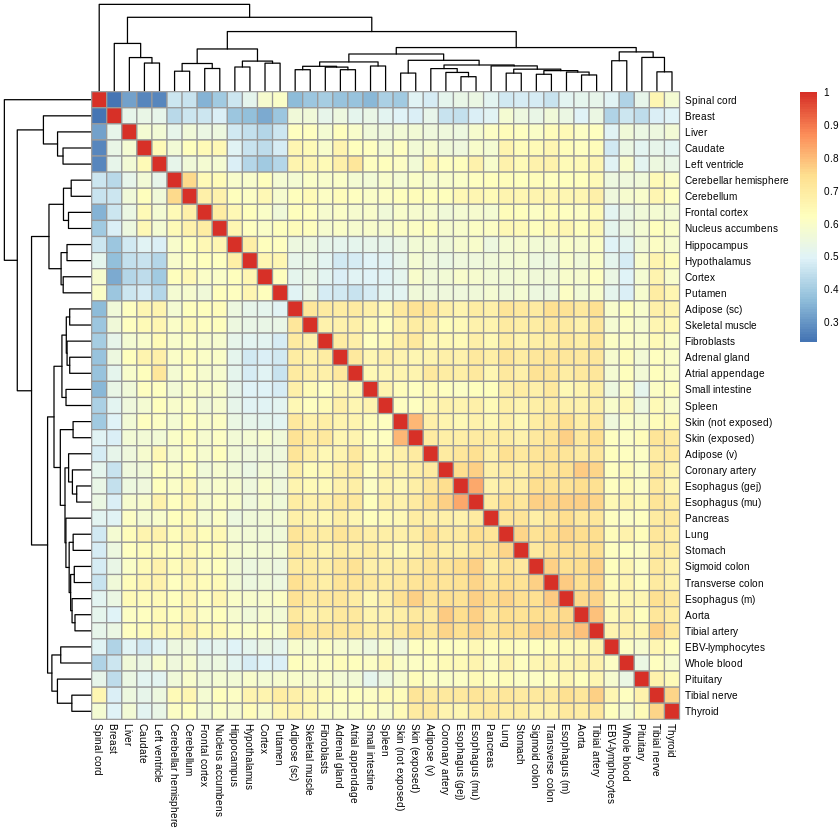

In [151]:
library(pheatmap)
pheatmap(as.matrix(dist_mat),   fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/Figure1c.pdf"))

# Figure 1e - Number of sex-biased AS events per tissue type.

In [ ]:
totals <- read.table("../dimorphAS/figures/figure1/Totals_by_tissue_annotated.txt", sep = "\t", quote = NULL, header = T)
totals_s <- totals %>% arrange(Total)
totals_s$Label <- factor(totals_s$Label, levels = totals_s$Label)


## Function to get a reverse log10 scale on the x axis
reverselog_trans <- function(base = exp(1)) {
  trans <- function(x) -log(x, base)
  inv <- function(x) base^(-x)
  trans_new(paste0("reverselog-", format(base)), trans, inv, 
            log_breaks(base = base), 
            domain = c(1e-100, Inf))
}



g<-ggplot(totals_s, aes(y = Label, x = Total, size = Total)) +
  geom_point(color = "red") +
  theme_bw() +
  scale_x_continuous(trans=reverselog_trans(), breaks=c(1,10,100,1000,5000,10000)) +#breaks=c(10000, 5000,1000,100,10,1)) +
  scale_y_discrete(position = "right") +
  theme(axis.text.x = element_text(size=8, angle = 0, hjust = 0.0, vjust = 0.5),
        axis.text.y = element_text(size=8),
        axis.title.x = element_text(face="plain", colour="black", 
                                    size=10),
        axis.title.y = element_blank(),
        legend.title=element_blank(),
        legend.text = element_text(face="plain", colour="black", 
                                   size=8)) +
  xlab(paste("Number of sex-biased splicing events")) +
  ylab("Tissue") + 
  guides(size=FALSE)

g
ggsave("../pdf/Figure1d.pdf",g, height = 4.5, width = 4)

# 5 Metadata

For replicability and reproducibility purposes, we also print the following metadata:

## 5.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [ ]:
figure_id   = "figure1"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", figure_id, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", figure_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

## 5.2. Library metadata

In [ ]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

In [ ]:
head(totals)

In [ ]:
sum(totals$Total)